# В этой тетрадке лежит мое решение 3 пункта (сначала я обучала здесь, чтобы ничего не сломать там, а теперь мне лень полчаса переобучать все заново в соседней тетрадке, извините :( ) 

Что я тут сделала:
- иначе предобработала данные, а именно:
- поставила порог 10, чтоб вошло больше слов и было больше совпадений с корпусом, с кот. мы сравниваем + авторы статьи советуют брать именно 10, а не 15
- просто взяла больше данных (до определенного момента больше=лучше)
- увеличила размерность векторов с 20 до 50, чтоб они содержали были более информативны

## Можно посмотреть, какие данные я загружаю, и дальше сразу листать к пункту _допишите обучалку_, больше я ничего тут не меняла по сравнению с соседней тетрадкой.

In [1]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [213]:
with open('/Users/veronicasmilga/Desktop/processed_corpus_large.json') as f:
    corpus = json.load(f)

In [214]:
len(corpus)

200000

In [215]:
for text in corpus[:5]:
    print(' '.join(text))

цена игра ##число руб платить ##число руб сверху минимум странно
какой мужчина искать женщина впихнуть хотеть нужный услуга
заведение карта отделение банк вы указать номер мобильный телефон
хотя отделение находиться далеко мой дом променять территориальный удобство качество обслуживание
звонок горячий линия оператор вообще сообщить банкомат принимать наличный


# CBOW

In [216]:
sample_text = corpus[1]

In [217]:
' '.join(sample_text)

'какой мужчина искать женщина впихнуть хотеть нужный услуга'

# Реализуйте разделение предложения на примеры методом CBOW

In [218]:
def cbow_split(tokens, window, pad_token='PAD'):
    splits = []
    for word in enumerate(tokens):
        left = []
        right = []
        for i in range(window):
            if (word[0] - i) > 0:
                token_left = tokens[word[0] - i - 1]
            else:
                token_left = pad_token
            try:
                token_right = tokens[word[0] + i + 1]
            except:
                token_right = pad_token
            left.append(token_left)
            right.append(token_right)
        splits.append((left[::-1], word[1], right))
    return splits

In [219]:
sample_text

['какой',
 'мужчина',
 'искать',
 'женщина',
 'впихнуть',
 'хотеть',
 'нужный',
 'услуга']

In [220]:
splits = cbow_split(sample_text, window=2)

In [221]:
for sample in splits:
    print(sample)

(['PAD', 'PAD'], 'какой', ['мужчина', 'искать'])
(['PAD', 'какой'], 'мужчина', ['искать', 'женщина'])
(['какой', 'мужчина'], 'искать', ['женщина', 'впихнуть'])
(['мужчина', 'искать'], 'женщина', ['впихнуть', 'хотеть'])
(['искать', 'женщина'], 'впихнуть', ['хотеть', 'нужный'])
(['женщина', 'впихнуть'], 'хотеть', ['нужный', 'услуга'])
(['впихнуть', 'хотеть'], 'нужный', ['услуга', 'PAD'])
(['хотеть', 'нужный'], 'услуга', ['PAD', 'PAD'])


In [222]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: какой
Правый контекст: ['мужчина', 'искать']

Левый контекст: ['PAD', 'какой']
Центральное слово: мужчина
Правый контекст: ['искать', 'женщина']

Левый контекст: ['какой', 'мужчина']
Центральное слово: искать
Правый контекст: ['женщина', 'впихнуть']

Левый контекст: ['мужчина', 'искать']
Центральное слово: женщина
Правый контекст: ['впихнуть', 'хотеть']

Левый контекст: ['искать', 'женщина']
Центральное слово: впихнуть
Правый контекст: ['хотеть', 'нужный']

Левый контекст: ['женщина', 'впихнуть']
Центральное слово: хотеть
Правый контекст: ['нужный', 'услуга']

Левый контекст: ['впихнуть', 'хотеть']
Центральное слово: нужный
Правый контекст: ['услуга', 'PAD']

Левый контекст: ['хотеть', 'нужный']
Центральное слово: услуга
Правый контекст: ['PAD', 'PAD']



In [223]:
splits

[(['PAD', 'PAD'], 'какой', ['мужчина', 'искать']),
 (['PAD', 'какой'], 'мужчина', ['искать', 'женщина']),
 (['какой', 'мужчина'], 'искать', ['женщина', 'впихнуть']),
 (['мужчина', 'искать'], 'женщина', ['впихнуть', 'хотеть']),
 (['искать', 'женщина'], 'впихнуть', ['хотеть', 'нужный']),
 (['женщина', 'впихнуть'], 'хотеть', ['нужный', 'услуга']),
 (['впихнуть', 'хотеть'], 'нужный', ['услуга', 'PAD']),
 (['хотеть', 'нужный'], 'услуга', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [224]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'какой', ['мужчина', 'искать', 'женщина']),
 (['PAD', 'PAD', 'какой'], 'мужчина', ['искать', 'женщина', 'впихнуть']),
 (['PAD', 'какой', 'мужчина'], 'искать', ['женщина', 'впихнуть', 'хотеть']),
 (['какой', 'мужчина', 'искать'], 'женщина', ['впихнуть', 'хотеть', 'нужный']),
 (['мужчина', 'искать', 'женщина'],
  'впихнуть',
  ['хотеть', 'нужный', 'услуга']),
 (['искать', 'женщина', 'впихнуть'], 'хотеть', ['нужный', 'услуга', 'PAD']),
 (['женщина', 'впихнуть', 'хотеть'], 'нужный', ['услуга', 'PAD', 'PAD']),
 (['впихнуть', 'хотеть', 'нужный'], 'услуга', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [225]:
' '.join(sample_text)

'какой мужчина искать женщина впихнуть хотеть нужный услуга'

# Реализуйте разделение предложения на примеры методом Skipgram

In [226]:
def skipgram_split(tokens, window):
    
    splits = []
    
    for word in enumerate(tokens):
        for i in range(window):
            if (word[0] - i) > 0:
                token_left = tokens[word[0] - i - 1]
                splits.append((token_left, word[1]))
            try:
                token_right = tokens[word[0] + i + 1]
                splits.append((token_right, word[1]))
            except:
                pass
    
    return splits

In [227]:
splits = skipgram_split(sample_text, window=2)

In [228]:
вопрос почему например китайский японский UNK

SyntaxError: invalid syntax (1885269162.py, line 1)

In [229]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: мужчина
Центральное слово: какой

Контекст: искать
Центральное слово: какой

Контекст: какой
Центральное слово: мужчина

Контекст: искать
Центральное слово: мужчина

Контекст: женщина
Центральное слово: мужчина

Контекст: мужчина
Центральное слово: искать

Контекст: женщина
Центральное слово: искать

Контекст: какой
Центральное слово: искать

Контекст: впихнуть
Центральное слово: искать

Контекст: искать
Центральное слово: женщина

Контекст: впихнуть
Центральное слово: женщина

Контекст: мужчина
Центральное слово: женщина

Контекст: хотеть
Центральное слово: женщина

Контекст: женщина
Центральное слово: впихнуть

Контекст: хотеть
Центральное слово: впихнуть

Контекст: искать
Центральное слово: впихнуть

Контекст: нужный
Центральное слово: впихнуть

Контекст: впихнуть
Центральное слово: хотеть

Контекст: нужный
Центральное слово: хотеть

Контекст: женщина
Центральное слово: хотеть

Контекст: услуга
Центральное слово: хотеть

Контекст: хотеть
Центральное слово: нужный

Контекст

In [230]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: мужчина
Центральное слово: какой

Контекст: искать
Центральное слово: какой

Контекст: какой
Центральное слово: мужчина

Контекст: искать
Центральное слово: мужчина

Контекст: женщина
Центральное слово: мужчина

Контекст: мужчина
Центральное слово: искать

Контекст: женщина
Центральное слово: искать

Контекст: какой
Центральное слово: искать

Контекст: впихнуть
Центральное слово: искать

Контекст: искать
Центральное слово: женщина

Контекст: впихнуть
Центральное слово: женщина

Контекст: мужчина
Центральное слово: женщина

Контекст: хотеть
Центральное слово: женщина

Контекст: женщина
Центральное слово: впихнуть

Контекст: хотеть
Центральное слово: впихнуть

Контекст: искать
Центральное слово: впихнуть

Контекст: нужный
Центральное слово: впихнуть

Контекст: впихнуть
Центральное слово: хотеть

Контекст: нужный
Центральное слово: хотеть

Контекст: женщина
Центральное слово: хотеть

Контекст: услуга
Центральное слово: хотеть

Контекст: хотеть
Центральное слово: нужный

Контекст

In [231]:
skipgram_split(sample_text, window=2)

[('мужчина', 'какой'),
 ('искать', 'какой'),
 ('какой', 'мужчина'),
 ('искать', 'мужчина'),
 ('женщина', 'мужчина'),
 ('мужчина', 'искать'),
 ('женщина', 'искать'),
 ('какой', 'искать'),
 ('впихнуть', 'искать'),
 ('искать', 'женщина'),
 ('впихнуть', 'женщина'),
 ('мужчина', 'женщина'),
 ('хотеть', 'женщина'),
 ('женщина', 'впихнуть'),
 ('хотеть', 'впихнуть'),
 ('искать', 'впихнуть'),
 ('нужный', 'впихнуть'),
 ('впихнуть', 'хотеть'),
 ('нужный', 'хотеть'),
 ('женщина', 'хотеть'),
 ('услуга', 'хотеть'),
 ('хотеть', 'нужный'),
 ('услуга', 'нужный'),
 ('впихнуть', 'нужный'),
 ('нужный', 'услуга'),
 ('хотеть', 'услуга')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [232]:
skipgram_split(sample_text, window=3)

[('мужчина', 'какой'),
 ('искать', 'какой'),
 ('женщина', 'какой'),
 ('какой', 'мужчина'),
 ('искать', 'мужчина'),
 ('женщина', 'мужчина'),
 ('впихнуть', 'мужчина'),
 ('мужчина', 'искать'),
 ('женщина', 'искать'),
 ('какой', 'искать'),
 ('впихнуть', 'искать'),
 ('хотеть', 'искать'),
 ('искать', 'женщина'),
 ('впихнуть', 'женщина'),
 ('мужчина', 'женщина'),
 ('хотеть', 'женщина'),
 ('какой', 'женщина'),
 ('нужный', 'женщина'),
 ('женщина', 'впихнуть'),
 ('хотеть', 'впихнуть'),
 ('искать', 'впихнуть'),
 ('нужный', 'впихнуть'),
 ('мужчина', 'впихнуть'),
 ('услуга', 'впихнуть'),
 ('впихнуть', 'хотеть'),
 ('нужный', 'хотеть'),
 ('женщина', 'хотеть'),
 ('услуга', 'хотеть'),
 ('искать', 'хотеть'),
 ('хотеть', 'нужный'),
 ('услуга', 'нужный'),
 ('впихнуть', 'нужный'),
 ('женщина', 'нужный'),
 ('нужный', 'услуга'),
 ('хотеть', 'услуга'),
 ('впихнуть', 'услуга')]

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [233]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [234]:
len(word2index)

16311

In [235]:
word2index['UNK']

158

In [236]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[2095, 13710, 158]

In [237]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[2095, 13710, 158]

# Torch Dataset
В торче есть очень удобная читалка данных

In [238]:
from torch.utils.data import Dataset, DataLoader

In [239]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [240]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.16462021, 0.95360952, 0.77728116, 0.26892962],
       [0.60687896, 0.88726017, 0.46366543, 0.34420933],
       [0.58779901, 0.48789286, 0.35729032, 0.12010267],
       [0.88588275, 0.50246001, 0.17039422, 0.905358  ],
       [0.08304003, 0.44898468, 0.68286037, 0.04710905],
       [0.35591772, 0.30534409, 0.89992887, 0.93106057],
       [0.56575448, 0.83829762, 0.32051827, 0.95572265],
       [0.42518288, 0.87467482, 0.02828927, 0.79773618],
       [0.90927306, 0.98711516, 0.96195912, 0.48698714],
       [0.75401462, 0.14424951, 0.78349292, 0.10998376]])

In [241]:
some_data_y

array([0, 0, 0, ..., 0, 1, 2])

In [242]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [243]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [244]:
some_dataset[5], some_dataset[467]

((array([0.35591772, 0.30534409, 0.89992887, 0.93106057]), 2),
 (array([0.14017649, 0.33727407, 0.15517331, 0.56464907]), 1))

In [245]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [246]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.2734, 0.2831, 0.7594, 0.2757],
         [0.9911, 0.2871, 0.2798, 0.8025],
         [0.9172, 0.9051, 0.3431, 0.5066],
         [0.4395, 0.3800, 0.6703, 0.7336],
         [0.6940, 0.1024, 0.6827, 0.1168],
         [0.0254, 0.3371, 0.7444, 0.5170],
         [0.7570, 0.4509, 0.7008, 0.2603],
         [0.4389, 0.1661, 0.3126, 0.5407],
         [0.4136, 0.1372, 0.3954, 0.1315],
         [0.7083, 0.9165, 0.8581, 0.8223],
         [0.7985, 0.1187, 0.4382, 0.1037],
         [0.2546, 0.0239, 0.0875, 0.7834],
         [0.4632, 0.3844, 0.6584, 0.9379],
         [0.7294, 0.6276, 0.7953, 0.8727],
         [0.8277, 0.3143, 0.4524, 0.5814],
         [0.3575, 0.4462, 0.3606, 0.5915]], dtype=torch.float64))

In [247]:
for x, y in some_loader:
    pass

len(x)

15

In [248]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [249]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [250]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [251]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [252]:
for x, y in toy_loader:
    break

In [253]:
x.shape

torch.Size([128, 32])

In [254]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.1646,   0.9536,   0.7773,  ...,  -0.2850,  -1.5117,  -7.8798],
        [  0.6069,   0.8873,   0.4637,  ...,  -0.7177,  -4.6116,  -6.3990],
        [  0.5878,   0.4879,   0.3573,  ...,  -4.3060,  -6.1752, -12.7164],
        ...,
        [  0.4853,   0.4090,   0.9201,  ...,  -5.3637,  -0.4996,  -8.1277],
        [  0.3564,   0.0311,   0.8815,  ..., -20.8170,  -0.7565, -17.7197],
        [  0.2304,   0.5448,   0.3232,  ...,  -3.6439,  -6.7762, -14.2695]],
       dtype=torch.float64)

In [255]:
y

tensor([0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1,
        1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 0, 1,
        2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2,
        2, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 1,
        2, 1, 2, 0, 1, 0, 2, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0,
        0, 1, 2, 0, 0, 2, 1, 0])

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [256]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [257]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y)
    
loss.item()

1.1028050184249878

# Боевые датасеты

In [258]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [259]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokens):
        splits = []

        for word in enumerate(tokens):
            for i in range(self.window):
                if (word[0] - i) > 0:
                    token_left = tokens[word[0] - i - 1]
                    splits.append((token_left, word[1]))
                try:
                    token_right = tokens[word[0] + i + 1]
                    splits.append((token_right, word[1]))
                except:
                    pass

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        context, central_word = self.data[idx]

        return context, central_word

In [260]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [261]:
dataset = SkipgramDataset(corpus, word2index)

100%|████████████████████████████████| 200000/200000 [00:04<00:00, 49602.03it/s]


In [262]:
BATCH_SIZE = 512

In [263]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [264]:
dataset_loader

In [265]:
for x, y in dataset_loader:
    break

In [266]:
x[:5]

tensor([ 827, 1183, 4377, 3541, 3276])

In [267]:
y[:5]

tensor([1776,  963, 4551, 1655,  210])

In [268]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [269]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [270]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [271]:
# CODE
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        #.sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

In [272]:
#from word2vec_utils import SkipGram

### Увеличенная размерность эмбеддинга

In [273]:
EMBEDDING_DIM = 50

In [274]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [275]:
#model = CBOW(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM, pad_index=1)

In [276]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 16311])

In [277]:
pred

tensor([[ 0.4847, -0.1799, -0.7460,  ...,  1.1363,  1.0111, -0.9720],
        [-0.5335,  0.1600, -0.2755,  ..., -0.1075, -0.8225,  0.5976],
        [ 0.5342, -0.1621,  1.0438,  ..., -1.0606, -0.4615,  0.0559],
        ...,
        [-0.2465,  0.9440,  0.4596,  ..., -0.3843,  0.1122,  0.4061],
        [-0.1210, -0.7189, -0.3066,  ..., -0.3908, -0.1262,  0.1986],
        [ 0.2020,  0.3000, -0.7036,  ...,  0.4318, -1.2632, -0.0818]])

In [278]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [279]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x_train, y_train in dataset_loader:

            # CODE
            
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            #optimizer.zero_grad()
            
            #loss = # CODE
            
            # CODE
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 1: 5964800it [20:37, 4818.58it/s, loss=7.29]                              
Epoch 2:  62%|██████▊    | 3696640/5964304 [12:40<07:46, 4861.51it/s, loss=7.16]


В какой-то момент на второй эпохе я прервала обучение, тк увидела, что лосс уже очень долгое время вообще не снижается и даже начал расти. Кажется, мы переобучились.

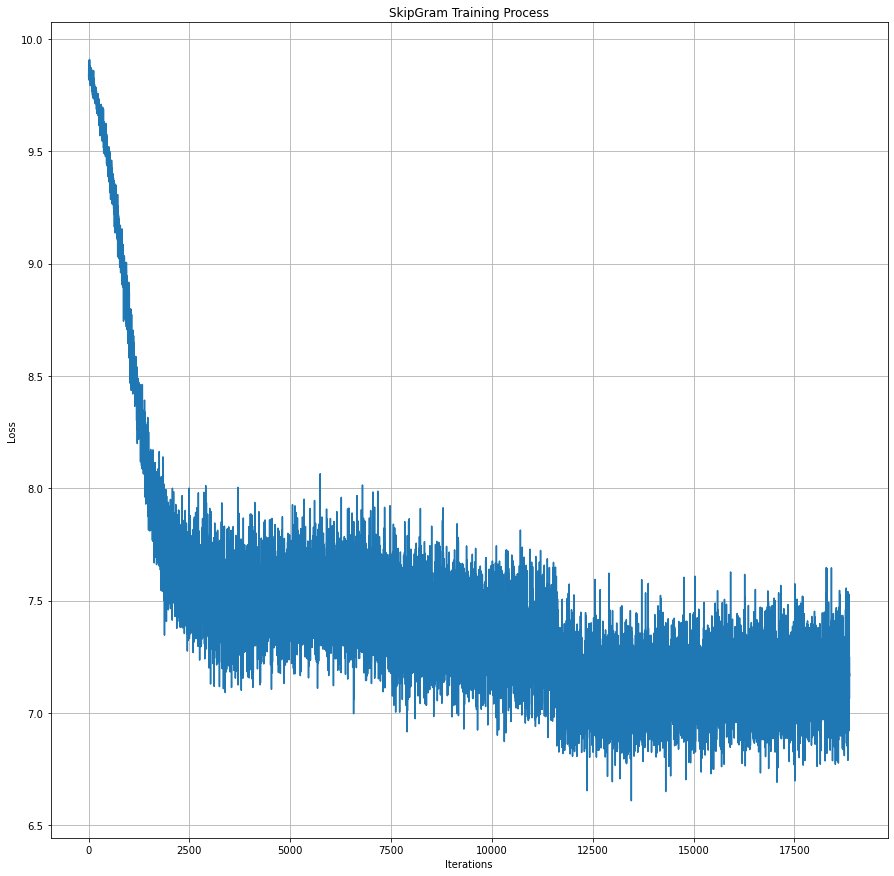

In [280]:
plt.title('SkipGram Training Process')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [281]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [282]:
embedding_matrix = model.in_embedding.weight.detach()

In [283]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [284]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.6460685729980469

In [285]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.6311913728713989

In [286]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

0.5170339345932007

In [287]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.6192866563796997

In [290]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "комфорт" равна 0.051'

### Тут кос.расстояние чуть изменилось, и мне кажется стало более логичным.

In [310]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [311]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [312]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16311 samples in 0.003s...
[t-SNE] Computed neighbors for 16311 samples in 6.266s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16311
[t-SNE] Computed conditional probabilities for sample 2000 / 16311
[t-SNE] Computed conditional probabilities for sample 3000 / 16311
[t-SNE] Computed conditional probabilities for sample 4000 / 16311
[t-SNE] Computed conditional probabilities for sample 5000 / 16311
[t-SNE] Computed conditional probabilities for sample 6000 / 16311
[t-SNE] Computed conditional probabilities for sample 7000 / 16311
[t-SNE] Computed conditional probabilities for sample 8000 / 16311
[t-SNE] Computed conditional probabilities for sample 9000 / 16311
[t-SNE] Computed conditional probabilities for sample 10000 / 16311
[t-SNE] Computed conditional probabilities for sample 11000 / 16311
[t-SNE] Computed conditional probabilities for sample 12000 / 16311
[t-SNE] Computed conditional probabilities for sam

In [313]:
top_words = [a for a,_ in top_sorted_freq]

In [314]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

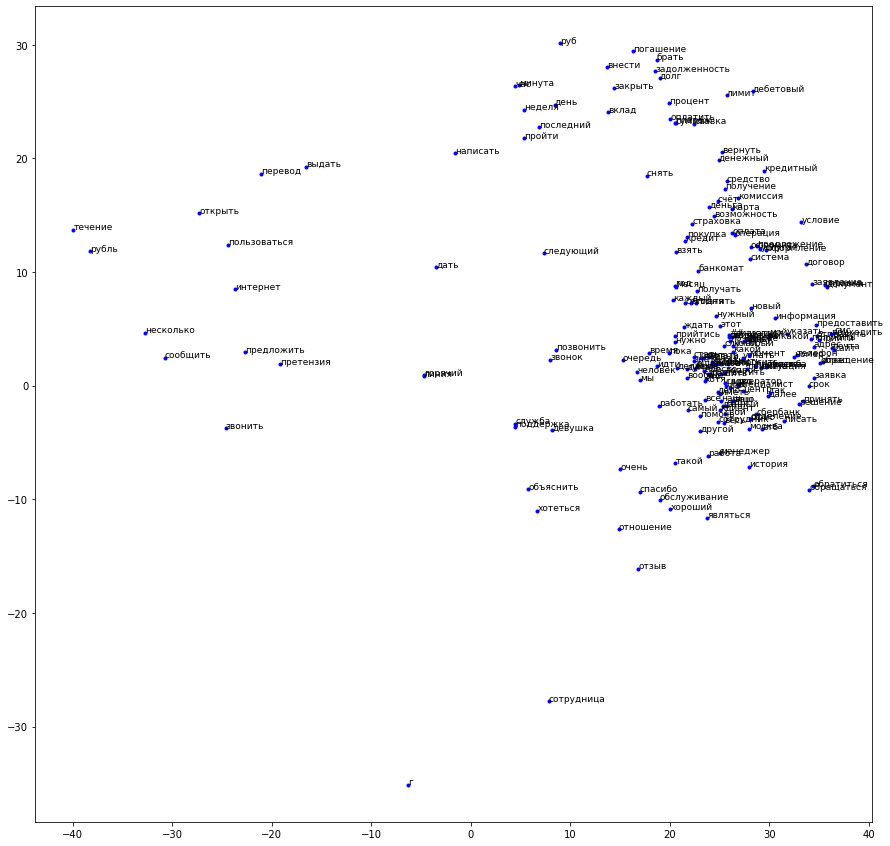

In [315]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

In [294]:
import pandas as pd
df = pd.read_csv("/Users/veronicasmilga/Desktop/ru_simlex965_tagged.tsv", sep='\t') 

In [295]:
def clean_text(text):
    return text.split('_')[0]

In [296]:
df['# Word1'] = df['# Word1'].apply(clean_text)
df['Word2'] = df['Word2'].apply(clean_text)

In [297]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Average Score']] = scaler.fit_transform(df[['Average Score']])

In [298]:
df["Average Score cossim"] = np.nan

In [299]:
c = 0
for index, row in df.iterrows():
        try:
            value = cos_sim(embedding_matrix, word2index, row['# Word1'], row['Word2'])
            df.loc[index, 'Average Score cossim'] = value
        except:
            c+=1
c

392

Обратим внимание на то, что сейчас у нас гораздо (почти на 80 штук) меньше слов, которые были в корпусе для оценки, но не попали в модель. Это связано с тем, как мы расширили датасет (почти в два раза).

In [305]:
df[['Average Score cossim']] = scaler.fit_transform(df[['Average Score cossim']])

In [306]:
df = df.dropna()

In [308]:
def get_mse(df, embedding_matrix, word2index):
    sum_err = 0
    num = 0
    out_of_voc = 0
    for index, row in df.iterrows():
        try:
            sum_err += (row['Average Score'] - row['Average Score cossim'])**2
            num += 1
        except:
            out_of_voc += 1
    MSE = sum_err/num
    return MSE

In [309]:
get_mse(df, embedding_matrix, word2index)

0.13758237137997295

Ура, мы уменьшили MSE на 0.04, взяв больше данных (200к вместо 100к) с меньшим порогом среза (10).